# Essai de modélisation des prix sur les données Airbnb de la ville de Paris

## Introduction

L'exercice réalisé dans ce notebook consistera a effectuer une modélisation des prix sur l'ensemble des appartement proposé sur le site Airbnb pour la ville de Paris.  
Compte tenu des caractéristiques de l'appartement (localisation, capacité d'accueil, nombre de chambre...), ainsi que des facilités de réservations proposées (nombre de nuits minimum et maximum, disponibilité du logement, réservation instantanée ou non, réglement en cas d'annulation...), quelle serait un prix à la nuit raisonable, aligné sur les prix des logements concurrents? Une telle modélisation pourrait par exemple être pertinente pour une personne s'inscrivant sur Airbnb pour y proposer un nouveau logement, et souhaitant définir un prix en ligne avec la concurrence.

#### Source de donnée
Les données utilisée pour ce projet ont été récupérées sur http://insideairbnb.com/. Ce site propose un ensemble de données issues d'Airbnb sur de nombreuses grandes villes à travers le monde, dont la ville de Paris.  
Il est bien précisé sur le site que ce service n'est pas associé ou soutenu par Airbnb. Les données n'ont donc pas été récupérées par des voies officielles et il conviendra donc de garder cela à l'esprit pour garder un oeil critique en cas d'incohérences, de données manquantes ou autres erreurs possibles.  

Pour chaque ville représentée sur le site, 7 tables sont proposées :
- listings.csv regroupe les informations sur chacune des annonces disponibles au sein de la ville, avec une ligne par annonce et l'ensemble de ses caractéristiques;
- calendar.csv contient une table d'évolution des prix pour chaque appartement; 
- reviews.csv est une table de commentaires sur chaque appartement;
- une table de résumé de listings, contenant moins d'informations que la table originale;
- une table de résumé de reviews, contenant moins d'informations que la table originale;
- neighbourhoods.csv contient une liste des quartiers de la ville;
- neighbourhoods.geojson contient les informations de géoréférencement des différents quartiers (qui correspondent en fait aux arrondissements de la ville), il pourra servir pour tracer des cartes.  

Ici j'utiliserai la table **listings.csv** pour mon analyse, qui contient l'ensemble des informations intéressantes sur chaque annonce. La table calendar pourrait être intéressante dans le cadre d'une modélisation dynamique des prix, mais ce ne sera pas le sujet. Ce projet consistera simplement à modéliser le prix de base rattaché à l'annonce. 

L'url de l'archive de la table utilisée est : http://data.insideairbnb.com/france/ile-de-france/paris/2019-09-16/data/listings.csv.gz.

#### Déroulement technique
Pour tenter de construire un modèle de prix, je vais me servir des possibilités offertes par la bibliothèque pySpark.  

Les étapes successives exposées dans ce document seront :
- le chargement et la mise en forme des données, du fichier brut à la mise en forme en DataFrame Spark ;
- l'exploration et le nettoyage des données, pour limiter la complexité de la modélisation ;
- une étape consistant à transformer les variables catégorielles en variables numériques grâce à l'encodage one-hot ;
- des essais de modélisation grâce à plusieurs algorithmes : moindres carrées ordinaires, moindres carrées régularisés et random forest.

## 1. Chargement et mise en forme des données

Cette étape consistera à charger les données en mémoire, et à les convertir sous forme de RDD puis de DataFrame pySpark pour pouvoir les manipuler plus simplement.

#### Import des bibliothèques principales

In [1]:
import pyspark
from pyspark import SparkContext
from pyspark import SQLContext
from pyspark.sql.types import *
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
import numpy as np
import csv
import pprint
import seaborn as sns
import operator
import pandas as pd
import geopandas as gpd

#### Lancement du SparkContext et du SQLContext

In [2]:
sc = SparkContext()
sqlContext = SQLContext(sc)

#### Import des fichiers de données 

In [3]:
# Accès aux fichiers
# A changer selon l'emplacement des données sur le disque
path_data = "/home/antonin/Documents/Cours-HeavyDocs/Projet_SD701/"
listings_csv = "listings.csv"

#### Fonctions de pré-formatage en RDD
Les fonctions suivantes serviront à formater les données sous forme de RDD. Cetains champs devront par la suite être transformés en flottants ou en entier, mais il faudra prendre en charge les champs non-remplis : je crée les fonctions toFloat et toInt pour gérer cela en transformant les champs numériques vides en None, une valeur reconnue par Spark.

In [4]:
# Fonction de découpage du CSV en lignes
def parseCSV(line):
    reader = csv.reader(line.splitlines(), skipinitialspace=True) 
    return(next(reader)) 

# Fonction de transformation en Float avec prise en charge des champs vides
def toFloat(field): 
    if field == '':
        return None
    else:
        return float(field) 

# Fonction de transformation en Integer avec prise en charge des champs vides
def toInt(field):
    if field == '':
        return None
    else:
        return int(field)

#### Création du RDD
Je crée ensuite un RDD à partir de la table csv, je supprime les éventuelles lignes vides, et j'applique la fonction parseCSV pour effectuer le découpage en champs différents à chaque ligne.

In [5]:
listings_rdd = sc.textFile(path_data + listings_csv)
listings_rdd = listings_rdd.filter(lambda line: line != '')
listings_rdd = listings_rdd.map(lambda x: parseCSV(x))

On peut maintenant afficher la liste des colonnes contenues dans le header du fichier :

In [6]:
# Affichage de la liste des colonnes du header
n_features = len(listings_rdd.take(1)[0])
feature_list = list(zip(listings_rdd.take(1)[0], list(range(n_features))))
print("nombre de features totales : ", n_features)
pprint.pprint(feature_list)

nombre de features totales :  106
[('id', 0),
 ('listing_url', 1),
 ('scrape_id', 2),
 ('last_scraped', 3),
 ('name', 4),
 ('summary', 5),
 ('space', 6),
 ('description', 7),
 ('experiences_offered', 8),
 ('neighborhood_overview', 9),
 ('notes', 10),
 ('transit', 11),
 ('access', 12),
 ('interaction', 13),
 ('house_rules', 14),
 ('thumbnail_url', 15),
 ('medium_url', 16),
 ('picture_url', 17),
 ('xl_picture_url', 18),
 ('host_id', 19),
 ('host_url', 20),
 ('host_name', 21),
 ('host_since', 22),
 ('host_location', 23),
 ('host_about', 24),
 ('host_response_time', 25),
 ('host_response_rate', 26),
 ('host_acceptance_rate', 27),
 ('host_is_superhost', 28),
 ('host_thumbnail_url', 29),
 ('host_picture_url', 30),
 ('host_neighbourhood', 31),
 ('host_listings_count', 32),
 ('host_total_listings_count', 33),
 ('host_verifications', 34),
 ('host_has_profile_pic', 35),
 ('host_identity_verified', 36),
 ('street', 37),
 ('neighbourhood', 38),
 ('neighbourhood_cleansed', 39),
 ('neighbourhood_gro

On constate qu'il y a 106 colonnes disponibles dans ce tableau, c'est beaucoup et je vais donc effectuer un tri basé sur plusieurs critères :  
1. La pertinence vis-à-vis de notre objectif :  
On se met à la place d'un nouvel utilisateur d'Airbnb, proposant un nouveau logement. Les critères entrant en compte sont donc les caractéristiques de l'appartement, et la flexibilité que l'hôte est prêt à mettre en place (degré de mise à disposition du logement, réglement en cas d'annulation...).  
Dans ce cadre, les données sur le nombre de commentaires et de notes, et sur la réactivité passée de l'hôte doivent être supprimées car elles ne s'appliquent pas pour un nouvel utilisateur.  
De même, je décide de ne pas garder les colonnes sur le prix pratiqué pour des personnes supplémentaires ou pour le ménage car elles pourraient être elles-même induites par le prix du logement.
2. La complexité de la modélisation :  
Certaines données semblent d'intérêt mais je n'ai pas encore les capacités techniques ou l'ambition de les utiliser : la description de l'appartement, du quartier ou encore les informations sur le transit seraient par exemple intéressantes à prendre en compte mais cela nécessiterait de les analyser avec du Natural Language Processing. La colonne "amenities" contient des informations intéressantes également mais elle serait complexe à manipuler du fait des nombreuses informations contenues.
3. Les données sans intérêt :  
On peut directement supprimer les données qui n'ont clairement pas d'intérêt pour l'analyse, comme par exemple les url, numéro d'identifiant, nom de l'hôte, les colonnes de localisation redondantes etc... Il y a aussi des colonnes dont on s'aperçoit directement en parcourant le fichier qu'elles sont très majoritairement non renseignées, comme les colonnes "experiences offered" ou "square_feet" par exemple.

Au final, je choisis de retenir les colonnes suivantes :
- neighbourhood_cleansed
- property_type
- room_type
- accommodates
- bathrooms
- bedrooms
- beds
- bed_type
- price
- guests_included
- minimum_nights
- maximum_nights
- availability_30
- availability_60
- availability_90
- availability_365
- instant_bookable
- is_business_travel_ready
- cancellation_policy

#### Création du DataFrame
Je vais créer un DataFrame à partir du RDD. Le DataFrame permettra une manipulation plus aisée et adaptée de mes données.

In [7]:
# Suppression du header
header = listings_rdd.take(1)
listings_rdd = listings_rdd.filter(lambda line: line != header[0])

Certaines lignes du RDD présentent des anomalies de structure causant des renvois d'erreurs lors de la transformation en DataFrame. La plupart du temps, cela semble être dû à des retours à la ligne au sein des champs descriptifs, ou à d'autres irrégularités de format de ce type. Afin de s'affranchir de ce problème, je vais simplement supprimer les lignes qui ne contiennent pas le bon nombre de champs :

In [8]:
# Filtre des lignes problématiques
listings_rdd = listings_rdd.filter(lambda line: len(line)==106)  
listings_rdd = listings_rdd.filter(lambda line: line[0].isdigit()) 

Pour le moment tous les champs de données sont de type String, la conversion en DataFrame nécessitera de les convertir vers le type adapté :

In [9]:
# Conversion des différents champs de données 
listings_cols = listings_rdd.map(lambda line: (line[39],
                                           line[51],
                                           line[52], 
                                           toInt(line[53]), 
                                           toFloat(line[54]), 
                                           toInt(line[55]),
                                           toInt(line[56]), 
                                           line[57],
                                           toInt(line[65]),
                                           toInt(line[67]),
                                           toInt(line[68]),
                                           toInt(line[77]),
                                           toInt(line[78]),
                                           toInt(line[79]),
                                           toInt(line[80]),
                                           line[96],
                                           line[97],
                                           line[98],
                                           toFloat(line[60].strip('$').replace(',','')))) # formatage des prix

Les prix ont également été convertis en flottants à cette étape. On note que c'est un signe "$" qui indiquait l'unité du prix mais on peut supposer qu'il s'agissait plutôt d'euros (pour rappel, les données ne sont pas officielles et il peut y avoir des erreurs). Je pourrai vérifier ce point par la suite en explorant les données.

Je crée le schéma du DataFrame, basé sur le type de données à recevoir, puis je crée le DataFrame lui-même :

In [10]:
# Création du schéma du DataFrame
listingsSchema = StructType([StructField("neighbourhood", StringType(), True),
                             StructField("property_type", StringType(), True),
                             StructField("room_type", StringType(), True),
                             StructField("accomodates", IntegerType(), True),
                             StructField("bathrooms", FloatType(), True),
                             StructField("bedrooms", IntegerType(), True),
                             StructField("beds", IntegerType(), True),
                             StructField("bed_type", StringType(), True),
                             StructField("guests_included", IntegerType(), True),
                             StructField("minimum_night", IntegerType(), True),
                             StructField("maximum_night", IntegerType(), True),
                             StructField("availability_30", IntegerType(), True),
                             StructField("availability_60", IntegerType(), True),
                             StructField("availability_90", IntegerType(), True),
                             StructField("availability_365", IntegerType(), True),
                             StructField("instant_bookable", StringType(), True),
                             StructField("is_business_travel_ready", StringType(), True),
                             StructField("cancellation_policy", StringType(), True),
                             StructField("price", FloatType(), True)])  

In [11]:
# Création du DataFrame
listings_df = sqlContext.createDataFrame(listings_cols, listingsSchema)

In [12]:
# Dimensions du DataFrame de départ
print("Longueur du DataFrame : {}, nombre de colonnes : {}".format(listings_df.count(), len(listings_df.columns)))

Longueur du DataFrame : 45836, nombre de colonnes : 19


In [13]:
# Affichage de la première ligne pour un aperçu du résultat
listings_df.take(1)

[Row(neighbourhood='Observatoire', property_type='Apartment', room_type='Entire home/apt', accomodates=2, bathrooms=1.0, bedrooms=0, beds=1, bed_type='Real Bed', guests_included=1, minimum_night=3, maximum_night=15, availability_30=22, availability_60=43, availability_90=44, availability_365=227, instant_bookable='f', is_business_travel_ready='f', cancellation_policy='flexible', price=60.0)]

## 2. Nettoyage et exploration des données

Cette étape consistera tout d'abord à effectuer quelques nettoyages basiques sur les données, puis à les examiner afin d'en tirer quelques informations utiles, en filtrant éventuellement les points qui pourraient causer des soucis par la suite.  
Pour la partie plus explorative, il serait possible de visualiser quantité d'informations mais je choisis ici de m'intéresser plus particulièrement à la répartition des prix, puis à l'impact du nombre de chambre et à celui de la localisation qui pourraient être des facteurs important dans la modélisation.

#### Nettoyage du DataFrame
A cette étape, je vais filtrer les données incohérentes encore contenues dans le DataFrame, afin d'avoir le moins possible de données faussées lors de la modélisation.  

Pour cela, je commence par filtrer les éventuelles valeurs nulles contenues dans les colonnes "accomodates", "bathrooms", "bedrooms", "beds", "guests_included" et "price" :

In [14]:
# Filtrage des prix nuls
listings_df = listings_df.filter((listings_df.accomodates > 0) &
                                (listings_df.bathrooms > 0) & 
                                (listings_df.bedrooms > 0) &
                                (listings_df.beds > 0) &
                                (listings_df.guests_included > 0) &
                                (listings_df.price > 0))

Je vais maintenant supprimer les types de propriété très peu représentés et/ou semblant fantaisistes, afin de limiter la complexité du modèle :

In [15]:
# Affichage des types de propriété et de leur nombre
listings_df.groupBy(["property_type"]).count().show(n=50)

+--------------------+-----+
|       property_type|count|
+--------------------+-----+
|           Apartment|31363|
|           Townhouse|  153|
|              Resort|    1|
|         Guest suite|   16|
|Casa particular (...|    2|
|      Boutique hotel|  413|
|                Loft|  698|
|          Guesthouse|   69|
|              Hostel|   46|
|                Cave|    2|
|               Villa|    8|
|            Campsite|    1|
|          Aparthotel|   16|
|               Other|   66|
|  Serviced apartment|  253|
|         Earth house|    3|
|               Hotel|  125|
|             Cottage|    2|
|        Nature lodge|    1|
|               Igloo|    1|
|         Condominium| 1001|
|               House|  311|
|                Boat|    8|
|          Tiny house|   11|
|           Houseboat|    7|
|            Bungalow|    1|
|   Bed and breakfast|  172|
+--------------------+-----+



In [16]:
# Filtre sur le type de propriété
property_type_list = ['Apartment', 'Townhouse', 'Boutique hotel', 'Loft', 
                      'Guesthouse', 'Hostel', 'Other', 'Serviced apartment', 'Hotel', 
                      'Condominium', 'House', 'Bed and breakfast']
listings_df = listings_df.filter(listings_df.property_type.isin(property_type_list))

On peux vérifier qu'il n'y a pas ce type de valeur fantaisistes dans les colonnes "room_type" et "bed_type" :

In [17]:
listings_df.groupBy(["room_type"]).count().show()

+---------------+-----+
|      room_type|count|
+---------------+-----+
|    Shared room|  319|
|Entire home/apt|29165|
|   Private room| 5186|
+---------------+-----+



In [18]:
listings_df.groupBy(["bed_type"]).count().show()

+-------------+-----+
|     bed_type|count|
+-------------+-----+
|       Airbed|   10|
|        Futon|  102|
|Pull-out Sofa|  567|
|        Couch|  123|
|     Real Bed|33868|
+-------------+-----+



#### Etude de la répartition des prix
Je commence par étudier la répartition des prix en traçant son histogramme et en calculant les statistiques principales :

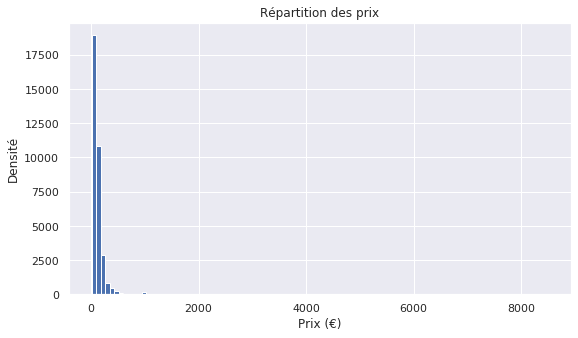

In [19]:
sns.set(rc={'figure.figsize': (9, 5)})

# Calcul de l'histogramme
bins, counts = listings_df.select("price").rdd.flatMap(lambda x: x).histogram(100)

# Affichage
fig, ax = plt.subplots()
plt.hist(bins[:-1], bins=bins, weights=counts)
plt.title('Répartition des prix')
plt.xlabel('Prix (€)')
plt.ylabel('Densité')
plt.show()

In [20]:
# Statistiques de prix
listings_df.describe(['price']).show()

+-------+------------------+
|summary|             price|
+-------+------------------+
|  count|             34670|
|   mean|119.09356792616094|
| stddev|134.23669390322246|
|    min|               8.0|
|    max|            8500.0|
+-------+------------------+



On voit que la très grande majorité des prix est distribuée vers les valeurs les plus faibles, et que les prix très élevés font figure d'outliers. A cette étape je pourrais choisir de travailler sur le logarithme des prix pour tenter de corriger cette distribution biaisée, mais on y perdrait en interprétabilité par la suite, notamment pour estimer les erreurs de modélisation. Je vais plutôt choisir de supprimer les locations proposées à plus de 500 € pour ne pas être influencé par les cas extrêmes.

In [21]:
listings_df = listings_df.filter(listings_df.price<500)

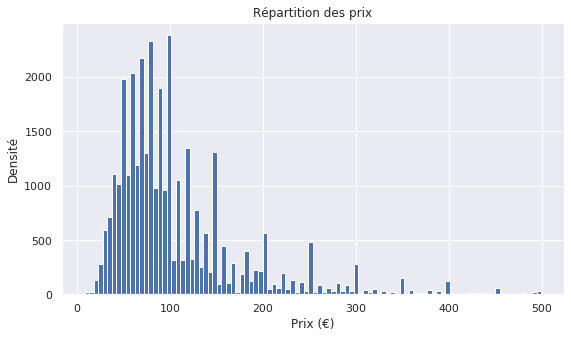

In [22]:
# Calcul du nouvel histogramme
bins, counts = listings_df.select("price").rdd.flatMap(lambda x: x).histogram(100)

# Affichage
fig, ax = plt.subplots()
plt.hist(bins[:-1], bins=bins, weights=counts)
plt.title('Répartition des prix')
plt.xlabel('Prix (€)')
plt.ylabel('Densité')
plt.show()

On s'aperçoit au passage que les prix ronds (100, 150, 200...) sont sur-représentés, ce qui valide l'hypothèse que les prix étaient bien en euros au départ.

#### Nombre de chambre
Le nombre de chambre de l'appartement devrait être une variable explicative importante, on peut en tracer l'histogramme de répartition, et avoir une première idée de son impact en calculant la moyenne des prix par nombre de chambres différents.

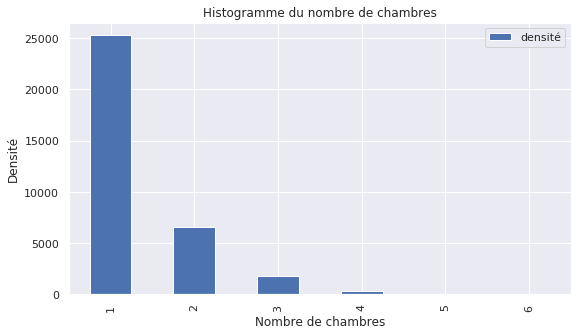

In [70]:
# Tracé de l'histogramme de répartition des nombres de chambres
max_bedrooms = listings_df.agg({"bedrooms": "max"}).collect()[0][0]
bedrooms_histogram = listings_df.select(
    "bedrooms").rdd.flatMap(lambda x: x).histogram(max_bedrooms-1)

pd.DataFrame(list(zip(*bedrooms_histogram)),
             columns=['bin', 'densité']).set_index('bin').plot(kind='bar')
plt.title("Histogramme du nombre de chambres")
plt.xlabel("Nombre de chambres")
plt.ylabel("Densité")
plt.show()

In [24]:
listings_df.groupBy(['bedrooms']).mean('price').sort(asc('bedrooms')).show()

+--------+------------------+
|bedrooms|        avg(price)|
+--------+------------------+
|       1| 87.05671878092222|
|       2|144.34172225591269|
|       3|206.30228667038483|
|       4|258.02793296089385|
|       5| 283.9423076923077|
|       6|             334.0|
|       7|             276.5|
+--------+------------------+



Sans surprise, la tendance globale montre que le prix moyen augmente avec le nombre de chambres. Cependant cette tendance générale n'est pas confirmée au delà de 6 chambres : en réalité les appartements de plus de 3 chambres sont rares et les moyennes sont donc calculées sur de petits échantillons pour ces appartements, les valeurs ne sont pas fiables.

#### Impact de la localisation
Intuitivement, la localisation de l'appartement devrait avoir un impact important, on peut vérifier comment se répartissent les prix en traçant une carte des prix moyens par arrondissement :

In [25]:
# Le fichier neighbourhoods.geojson qui contient les informations de géoréférencement
url = "http://data.insideairbnb.com/france/ile-de-france/paris/2019-09-16/visualisations/neighbourhoods.geojson"
neighbourhoods_shape = gpd.read_file(url)

# Calcul des moyennes de prix par arrondissement et enregistrement en DataFrame pandas
neighbourhood_price = listings_df.groupBy(['neighbourhood']).mean('price')
neighbourhood_price_df = neighbourhood_price.toPandas()

# Création d'un dataframe contenant le géoréférencement des arrondissement et la moyenne des prix
neighbourhood_table = neighbourhoods_shape.merge(neighbourhood_price_df)[['neighbourhood', 'geometry', 'avg(price)']]

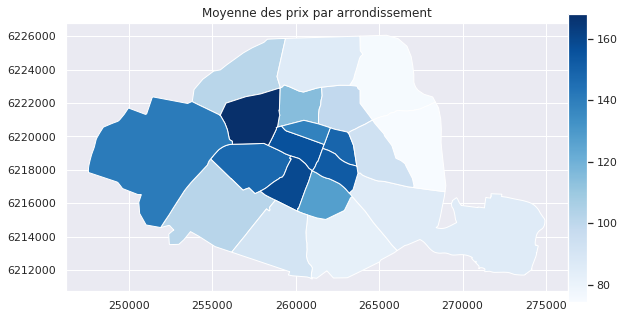

In [26]:
# Tracé de la carte
neighbourhood_table = neighbourhood_table.to_crs({'init': 'epsg:3395'})  # mercator projection

vmin, vmax = neighbourhood_table['avg(price)'].min(), neighbourhood_table['avg(price)'].max()
ax = neighbourhood_table.plot(column='avg(price)', 
                              cmap='Blues', 
                              vmin=vmin, 
                              vmax=vmax)
fig = ax.get_figure()
plt.title('Moyenne des prix par arrondissement')
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, cax=cax)
plt.show()

On voit que les moyennes de prix peuvent varier du simple au double selon l'arrondissement, la localisation pourrait jouer un rôle important dans notre modélisation.

In [27]:
# Dimensions du DataFrame après la phase d'exploration et de nettoyage
print("Longueur du DataFrame : {}, nombre de colonnes : {}".format(listings_df.count(), len(listings_df.columns)))

Longueur du DataFrame : 34070, nombre de colonnes : 19


## 3. Encodage des variables catégorielles

Cette étape va consister à effectuer des modifications sur les données catégorielles afin qu'elles puissent être ingérées par les algorithmes d'apprentissage utilisés par la suite.  
Pour cela il va falloir transformer les variables catégorielles (telles que "neighbourhood", "bed_type", etc) en variables numériques. Dans ce but, j'utiliserai l'encodage one-hot : il consiste à représenter une variable catégorielle en un vecteur contenant uniquement des 0 et des 1, de taille égale au nombre de catégories possibles pour cette variable. Pour chaque échantillon, la valeur 1 sera affectée à l'indice de sa catégorie, et toutes les autres valeurs du vecteur seront mise égale à 0. 

Je commence par appliquer la fonction *StringIndexer* de pyspark sur chaque variable catégorielle. C'est une étape préliminaire à l'encodage one-hot : elle permet de transformer une catégorie en son indice parmi l'ensemble des catégories possibles pour une variable.

In [28]:
from pyspark.ml.feature import StringIndexer

# Transformation des catégories en index

indexer = StringIndexer(inputCol="neighbourhood", outputCol="neighbourhoodIndex")
listings_df = indexer.fit(listings_df).transform(listings_df)

indexer = StringIndexer(inputCol="property_type", outputCol="property_typeIndex")
listings_df = indexer.fit(listings_df).transform(listings_df)

indexer = StringIndexer(inputCol="room_type", outputCol="room_typeIndex")
listings_df = indexer.fit(listings_df).transform(listings_df)

indexer = StringIndexer(inputCol="bed_type", outputCol="bed_typeIndex")
listings_df = indexer.fit(listings_df).transform(listings_df)

indexer = StringIndexer(inputCol="instant_bookable", outputCol="instant_bookableIndex")
listings_df = indexer.fit(listings_df).transform(listings_df)

indexer = StringIndexer(inputCol="is_business_travel_ready", outputCol="is_business_travel_readyIndex")
listings_df = indexer.fit(listings_df).transform(listings_df)

indexer = StringIndexer(inputCol="cancellation_policy", outputCol="cancellation_policyIndex")
listings_df = indexer.fit(listings_df).transform(listings_df)

Il va falloir garder une trace pour la correspondance entre les différentes catégories et les indices qui les représentent. Je crée un dictionnaire indice/catégorie pour chaque variable catégorielle dans ce but:

In [29]:
# Création des dictionnaires indices-catégorie pour chaque variable catégorielle
# Y-a-t-il un moyen plus direct d'obtenir les correspondances que la méthode suivante?

neighbourhoodList = [f.metadata for f in listings_df.schema.fields if f.name == "neighbourhoodIndex"]
neighbourhoodDict = dict(enumerate(neighbourhoodList[0]["ml_attr"]["vals"]))

property_typeList = [f.metadata for f in listings_df.schema.fields if f.name == "property_typeIndex"]
property_typeDict = dict(enumerate(property_typeList[0]["ml_attr"]["vals"]))

room_typeList = [f.metadata for f in listings_df.schema.fields if f.name == "room_typeIndex"]
room_typeDict = dict(enumerate(room_typeList[0]["ml_attr"]["vals"]))

bed_typeList = [f.metadata for f in listings_df.schema.fields if f.name == "bed_typeIndex"]
bed_typeDict = dict(enumerate(bed_typeList[0]["ml_attr"]["vals"]))

instant_bookableList = [f.metadata for f in listings_df.schema.fields if f.name == "instant_bookableIndex"]
instant_bookableDict = dict(enumerate(instant_bookableList[0]["ml_attr"]["vals"]))

is_business_travel_readyList = [f.metadata for f in listings_df.schema.fields if f.name == "is_business_travel_readyIndex"]
is_business_travel_readyDict = dict(enumerate(is_business_travel_readyList[0]["ml_attr"]["vals"]))

cancellation_policyList = [f.metadata for f in listings_df.schema.fields if f.name == "cancellation_policyIndex"]
cancellation_policyDict = dict(enumerate(cancellation_policyList[0]["ml_attr"]["vals"]))

Je peux maintenant appliquer l'encodage one-hot:

In [30]:
# OneHotEncoder, transforme les index en vecteurs avec valeur 1 à l'indice correspondant
from pyspark.ml.feature import OneHotEncoderEstimator

inputCols = ["neighbourhoodIndex", 
             "property_typeIndex", 
             "room_typeIndex", 
             "bed_typeIndex", 
             "instant_bookableIndex",
             "is_business_travel_readyIndex",
             "cancellation_policyIndex"]

outputCols = ["neighbourhoodVec", 
              "property_typeVec", 
              "room_typeVec", 
              "bed_typeVec", 
              "instant_bookableVec",
              "is_business_travel_readyVec",
              "cancellation_policyVec"]

encoder = OneHotEncoderEstimator(inputCols=inputCols, outputCols=outputCols, dropLast=False)
    
model = encoder.fit(listings_df)
listings_df = model.transform(listings_df)

La fonction *VectorAssembler* va maintenant permettre de combiner l'ensemble des features sous forme vectorielle :

In [31]:
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols = ["neighbourhoodVec", 
                                               "property_typeVec", 
                                               "room_typeVec", 
                                               "accomodates",
                                               "bathrooms", 
                                               "bedrooms", 
                                               "beds", 
                                               "bed_typeVec",
                                               "guests_included",
                                               "minimum_night",
                                               "maximum_night",
                                               "availability_30",
                                               "availability_60",
                                               "availability_90",
                                               "availability_365",
                                               "instant_bookableVec",
                                               "is_business_travel_readyVec",
                                               "cancellation_policyVec"], 
                                  outputCol = 'features', 
                                  handleInvalid="skip")

vlistings_df = vectorAssembler.transform(listings_df)
vlistings_df = vlistings_df.select(['features', 'price'])

A ce stade, je crée un dictionnaire de l'ensemble des features obtenus, pour savoir quel est l'indice de chaque feature possible suite à la création de l'encodage one-hot :

In [32]:
# Dictionnaire de tous les features
featuresList = ["neighbourhood: " + string for string in neighbourhoodList[0]["ml_attr"]["vals"]] + \
    ["property_type: " + string for string in property_typeList[0]["ml_attr"]["vals"]] + \
    ["room_type: " + string for string in room_typeList[0]["ml_attr"]["vals"]] + \
    ["accomodates"] + \
    ["bathrooms"] + \
    ["bedrooms"] + \
    ["beds"] + \
    ["bed_type: " + string for string in bed_typeList[0]["ml_attr"]["vals"]] + \
    ["guests_included"] + \
    ["minimum_night"] + \
    ["maximum_night"] + \
    ["availability_30"] + \
    ["availability_60"] + \
    ["availability_90"] + \
    ["availability_365"] + \
    ["instant_bookable: " + string for string in instant_bookableList[0]["ml_attr"]["vals"]] + \
    ["is_business_travel_ready: " + string for string in is_business_travel_readyList[0]["ml_attr"]["vals"]] + \
    ["cancellation_policy: " + string for string in cancellation_policyList[0]["ml_attr"]["vals"]]
    
featuresDict = dict(enumerate(featuresList))

In [33]:
featuresDict

{0: 'neighbourhood: Buttes-Montmartre',
 1: 'neighbourhood: Popincourt',
 2: 'neighbourhood: Vaugirard',
 3: 'neighbourhood: Entrepôt',
 4: 'neighbourhood: Batignolles-Monceau',
 5: 'neighbourhood: Ménilmontant',
 6: 'neighbourhood: Buttes-Chaumont',
 7: 'neighbourhood: Passy',
 8: 'neighbourhood: Opéra',
 9: 'neighbourhood: Temple',
 10: 'neighbourhood: Reuilly',
 11: 'neighbourhood: Observatoire',
 12: 'neighbourhood: Gobelins',
 13: 'neighbourhood: Panthéon',
 14: 'neighbourhood: Hôtel-de-Ville',
 15: 'neighbourhood: Bourse',
 16: 'neighbourhood: Luxembourg',
 17: 'neighbourhood: Palais-Bourbon',
 18: 'neighbourhood: Élysée',
 19: 'neighbourhood: Louvre',
 20: 'property_type: Apartment',
 21: 'property_type: Condominium',
 22: 'property_type: Loft',
 23: 'property_type: Boutique hotel',
 24: 'property_type: House',
 25: 'property_type: Serviced apartment',
 26: 'property_type: Bed and breakfast',
 27: 'property_type: Townhouse',
 28: 'property_type: Hotel',
 29: 'property_type: Gues

In [34]:
vlistings_df.take(1)

[Row(features=SparseVector(60, {14: 1.0, 20: 1.0, 32: 1.0, 35: 4.0, 36: 1.0, 37: 2.0, 38: 2.0, 39: 1.0, 44: 2.0, 45: 10.0, 46: 23.0, 48: 3.0, 49: 3.0, 50: 240.0, 51: 1.0, 53: 1.0, 56: 1.0}), price=115.0)]

Le DataFrame obtenu contient les features sous forme d'un SparseVector de longueur égale à 60. Ce SparseVecteur contient les indices et valeurs de toutes les composantes qui ne sont pas égales à 0. Le prix est contenu dans une variable séparée du SparseVector.

## 4. Modélisation

Je vais maintenant modéliser les données en utilisant 2 méthodes de régression linéaire : les moindres carrées ordinaires puis la régression avec régularisation. Ces deux algorithmes ont été choisis car ce sont des algorithmes de base en régression, et je comprend bien à quoi correspondent leur différents paramètres.
Dans un second temps, j'essayerai d'appliquer un modèle non linéaire pour tenter d'améliorer les résultats, en appliquant l'algorithme du Random Forest qui m'est moins familier. Je pourrait voir si il permet d'être plus précis dans ce contexte.

Je commence par diviser aléatoirement le jeu de données en un jeu d'entrainement et un jeu de test :

In [35]:
# split en dataframes train et test
splits = vlistings_df.randomSplit([0.8, 0.2])
train_df = splits[0]
test_df = splits[1]

Je crée ensuite les fonctions d'évaluation des modèles. Je vais évaluer : 
- le coefficient ${R²}$ qui mesurera le pourcentage de variabilité du prix expliqué par le modèle ;
- le RMSE (Root Mean Square Error) qui permettra d'obtenir une indication sur l'amplitude moyenne des erreurs ;
- le MAE (Mean Absolute Error) qui représente également une mesure d'erreur, mais moins sensible aux erreurs extrêmes que le RMSE, ce pourrait être une mesure d'erreur intéressante ici car la distribution des prix est biaisée par les valeurs élevées.

In [36]:
# Fonctions d'évaluations
from pyspark.ml.evaluation import RegressionEvaluator

R2_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="price", metricName="r2")
RMSE_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="price", metricName="rmse")
MAE_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="price", metricName="mae")

### Régression linéaire OLS
Je commence par réaliser une modélisation par les moindres carrées ordinaires.

In [37]:
from pyspark.ml.regression import LinearRegression

# Paramètres de la régression: regParam=0 pour la régression OLS
linreg = LinearRegression(featuresCol = 'features', \
                      labelCol='price', \
                      maxIter=100, \
                      regParam=0.0, \
                      elasticNetParam=0)

# Entrainement du modèle
OLS_model = linreg.fit(train_df)

# Calcul des prédictions sur le jeu d'entrainement
predictions_train = OLS_model.transform(train_df)

In [38]:
# Affichage des indicateurs de performance
OLS_train_R2 = R2_evaluator.evaluate(predictions_train)
OLS_train_RMSE = RMSE_evaluator.evaluate(predictions_train)
OLS_train_MAE = MAE_evaluator.evaluate(predictions_train)
print("Coefficient R2 sur le jeu d'entrainement : %g" % OLS_train_R2)
print("RMSE sur le jeu d'entrainement : %g" % OLS_train_RMSE)
print("MAE sur le jeu d'entrainement : %g" % OLS_train_MAE)

Coefficient R2 sur le jeu d'entrainement : 0.570784
RMSE sur le jeu d'entrainement : 46.4111
MAE sur le jeu d'entrainement : 31.5038


In [39]:
# Calcul des prédictions sur le jeu de test
predictions_test = OLS_model.transform(test_df)

# Affichage des indicateurs de performance
OLS_test_R2 = R2_evaluator.evaluate(predictions_test)
OLS_test_RMSE = RMSE_evaluator.evaluate(predictions_test)
OLS_test_MAE = MAE_evaluator.evaluate(predictions_test)
print("Coefficient R2 sur le jeu de test : %g" % OLS_test_R2)
print("RMSE sur le jeu de test : %g" % OLS_test_RMSE)
print("MAE sur le jeu de test : %g" % OLS_test_MAE)

Coefficient R2 sur le jeu de test : 0.573659
RMSE sur le jeu de test : 45.9461
MAE sur le jeu de test : 31.5068


### Régression linéaire avec régularisation
Je va appliquer une régularisation à la régression, on jouant sur 2 paramètres :
- le facteur de régularisation regParam ;
- le compromis de régularisation L1/L2, défini par elasticNetParam ;  

Je vais créer une grille sur ces 2 paramètres puis rechercher la meilleure combinaison de ces 2 facteurs sur cette grille, grâce à un jeu de cross-validation. L'évaluation des modèles se fera sur le MAE, plus robuste aux valeurs extrêmes.

In [40]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Création de la grille de recherche d'hyperparamètres
paramGrid = ParamGridBuilder()\
    .addGrid(linreg.regParam, [0.001, 0.01, 0.1, 1, 10, 100, 1000]) \
    .addGrid(linreg.elasticNetParam, [0, 0.25, 0.5, 0.75, 1])\
    .build()

# Evaluation du modèle sur le MAE
evaluator = MAE_evaluator

# Cross-validation
crossval = CrossValidator(estimator=linreg,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)

# Lancement du TrainValidationSplit et choix des meilleurs paramètres
model_CV = crossval.fit(train_df)

# Prédiction effectuées grâce au meilleurs modèle trouvé
predictions = model_CV.transform(test_df)

In [42]:
# Affichage des meilleurs paramètres sélectionnés
print("regParam : ", model_CV.bestModel._java_obj.getRegParam())
print("elasticNetParam : ", model_CV.bestModel._java_obj.getElasticNetParam())

regParam :  1.0
elasticNetParam :  1.0


In [41]:
# Affichage des indicateurs de performance
LRR_R2 = R2_evaluator.evaluate(predictions)
LRR_RMSE = RMSE_evaluator.evaluate(predictions)
LRR_MAE = MAE_evaluator.evaluate(predictions)
print("Coefficient R2 sur le jeu de test : %g" % LRR_R2)
print("RMSE sur le jeu de test : %g" % LRR_RMSE)
print("MAE sur le jeu de test : %g" % LRR_MAE)

Coefficient R2 sur le jeu de test : 0.569864
RMSE sur le jeu de test : 46.1502
MAE sur le jeu de test : 31.3337


On s'aperçoit que la régularisation n'a pas permis d'améliorer le modèle, les indicateurs de performance sont du même ordre de grandeur.

### Random Forest
Je vais maintenant essayer d'appliquer l'algorithme du random forest. Peut-être qu'une méthode non linéaire parviendra mieux à rendre compte de la complexité des données.

In [43]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator

# Train a RandomForest model
rf = RandomForestRegressor(featuresCol="features", labelCol='price') 

# Train model.  This also runs the indexer
model = rf.fit(train_df)

# Make predictions
predictions_train = model.transform(train_df)
predictions_test = model.transform(test_df)

In [44]:
# Affichage des indicateurs de performance
rf_R2_train = R2_evaluator.evaluate(predictions_train)
rf_RMSE_train = RMSE_evaluator.evaluate(predictions_train)
rf_MAE_train = MAE_evaluator.evaluate(predictions_train)
print("Coefficient R2 sur le jeu d'entrainement : %g" % rf_R2_train)
print("RMSE sur le jeu d'entrainement : %g" % rf_RMSE_train)
print("MAE sur le jeu d'entrainement : %g" % rf_MAE_train)

print('===================================================')

rf_R2_test = R2_evaluator.evaluate(predictions_test)
rf_RMSE_test = RMSE_evaluator.evaluate(predictions_test)
rf_MAE_test = MAE_evaluator.evaluate(predictions_test)
print("Coefficient R2 sur le jeu de test : %g" % rf_R2_test)
print("RMSE sur le jeu de test : %g" % rf_RMSE_test)
print("MAE sur le jeu de test : %g" % rf_MAE_test)

Coefficient R2 sur le jeu d'entrainement : 0.491354
RMSE sur le jeu d'entrainement : 50.5233
MAE sur le jeu d'entrainement : 34.2696
Coefficient R2 sur le jeu de test : 0.486736
RMSE sur le jeu de test : 50.4128
MAE sur le jeu de test : 34.4598


Le random forest avec ses paramètres par défaut ne fait pas de miracles, la régression linéaire offre de meilleurs résultats.  
Je vais essayer de régler quelques-uns des hyper-paramètres de l'algorithme pour tenter de faire mieux.

### Random Forest avec recherche des hyperparamètres
Parmis les hyper-paramètres de l'algorithme, je choisis de jouer sur la profondeur des arbres (maxDepth) et sur leur nombre (numTrees). Malheureusement, je suis très limité dans cette recherche car cet algorithme est couteux et je n'ai pas les capacités de calcul pour faire un balayage plus exhaustif, avec plus de paramètres et des fourchettes de valeur plus étendues. Je suis même obligé d'effectuer ma recherche en séquentiel sur les 2 paramètres choisis pour que cela fonctionne :

In [45]:
# Création de la grille de recherche d'hyperparamètres
paramGrid = ParamGridBuilder()\
    .addGrid(rf.maxDepth, [5, 10, 20, 30]) \
    .build()

# Evaluation du modèle sur le MAE
evaluator = MAE_evaluator

# Cross-validation
crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)

# Lancement du TrainValidationSplit et choix des meilleurs paramètres
model_CV = crossval.fit(train_df)

# Prédiction effectuées grâce au meilleurs modèle trouvé
predictions = model_CV.transform(test_df)

In [46]:
maxDepth = model_CV.bestModel._java_obj.getMaxDepth()

In [47]:
# Création de la grille de recherche d'hyperparamètres
paramGrid = ParamGridBuilder()\
    .addGrid(rf.maxDepth, [maxDepth]) \
    .addGrid(rf.numTrees, [20, 25, 30]) \
    .build()

# Evaluation du modèle sur le MAE
evaluator = MAE_evaluator

# Cross-validation
crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)

# Lancement du TrainValidationSplit et choix des meilleurs paramètres
model_CV = crossval.fit(train_df)

# Prédiction effectuées grâce au meilleurs modèle trouvé
predictions = model_CV.transform(test_df)

In [49]:
print("maxDepth : ", maxDepth)
print("numTrees : ", model_CV.bestModel._java_obj.getNumTrees())

maxDepth :  20
numTrees :  25


In [48]:
# Affichage des indicateurs de performance
rfh_R2 = R2_evaluator.evaluate(predictions)
rfh_RMSE = RMSE_evaluator.evaluate(predictions)
rfh_MAE = MAE_evaluator.evaluate(predictions)
print("Coefficient R2 sur le jeu de test : %g" % rfh_R2)
print("RMSE sur le jeu de test : %g" % rfh_RMSE)
print("MAE sur le jeu de test : %g" % rfh_MAE)

Coefficient R2 sur le jeu de test : 0.57021
RMSE sur le jeu de test : 46.1316
MAE sur le jeu de test : 30.6862


Finalement, la performance est meilleurs qu'avec les réglages de base en random forest, mais reste quasiment la même que par régression linéaire ordinaire.

Cependatn, un point intéressant de l'algorithme du random forest est qu'il permet d'afficher l'importance détectée des features. Dans le contexte de cette modélisation, cela permet par exemple de savoir quels sont les facteurs les plus importants pour fixer un prix à la nuit :

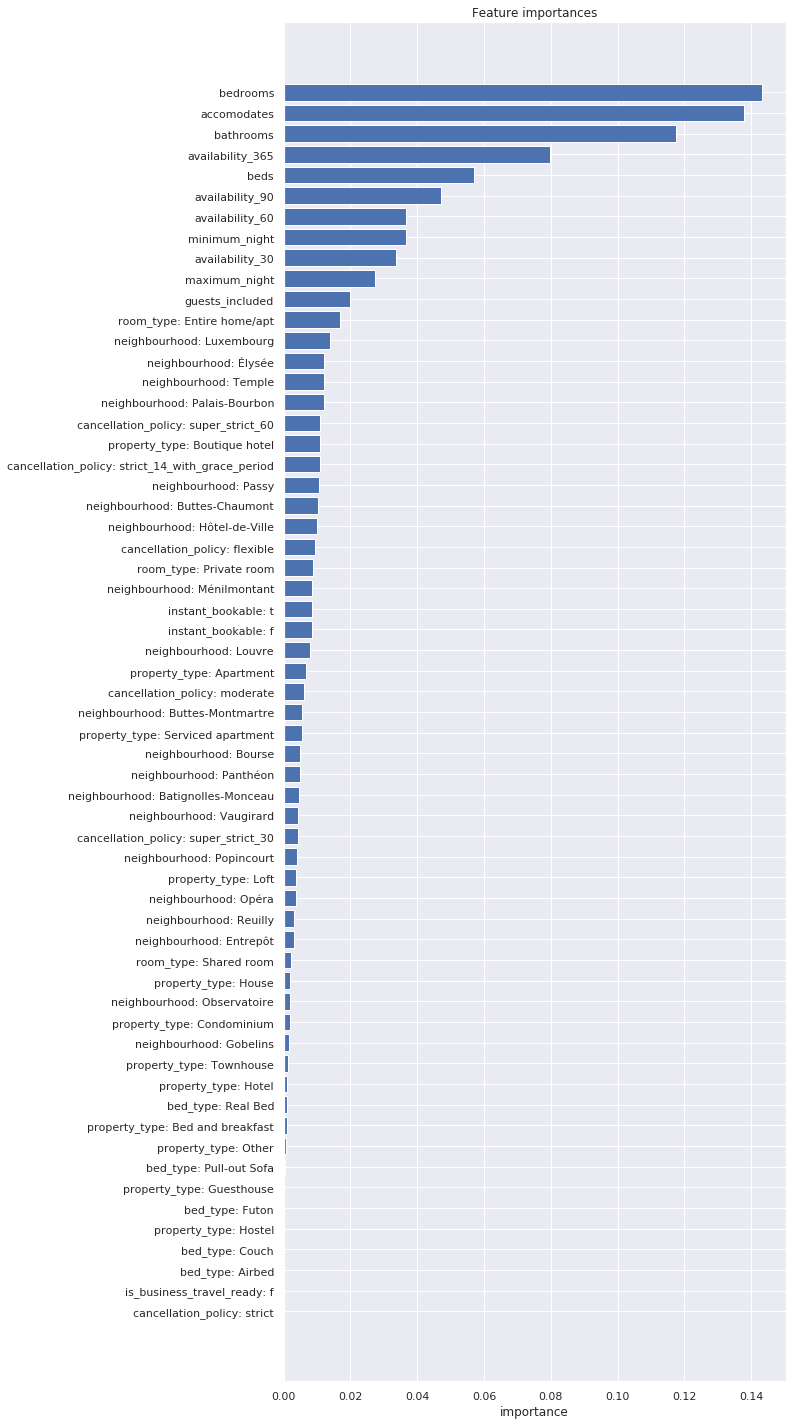

In [50]:
# Création de la liste des features ordonnés par ordre d'importance
features_impt = dict(zip(featuresList, [i for i in model_CV.bestModel.featureImportances]))
features_impt = sorted(features_impt.items(), key=operator.itemgetter(1), reverse=True)

# Création de l'histogramme
features_impt.reverse()
features = [tup[0] for tup in features_impt]
importances = [tup[1] for tup in features_impt]
y_pos = np.arange(len(features)) 

fig, ax = plt.subplots(figsize=(9, 25))
plt.barh(y_pos, importances, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(features) 
ax.set_xlabel('importance')
ax.set_title('Feature importances')
plt.show()

Le nombre de chambre et de lit, la capacité d'accueil, le nombre de salles de bain et la disponibilité de l'appartement dans les prochaines périodes semblent jouer les rôles les plus importants.

## Conclusion
Le travail effectué a montré la démarche à suivre pour prendre en charge un jeu de données et se servir des outils offerts par la bibliothèque PySpark. La conversion en DataFrame, le nettoyage, l'exploration et la modélisation des données ont été abordés.  
Concernant les résultats obtenus, les performances sont très similaires entre régression linéaire ordinaire et random forest avec recherche sur les hyper-paramètres. Avec ces modèles, le RMSE atteint alors 46 €, le MAE 30 €, et la modélisation explique 57 % de la variabilité des prix. Ce résultat ne semble pas très bon dans l'absolu, et on peux penser que de nombreux facteurs importants n'ont pas pu être pris en compte dans cette modélisation simple. Pour améliorer le modèle grace aux données disponible, on pourrait par exemple :
- utiliser des méthodes de NLP pour analyser la description de l'appartement et de l'hôte ;
- prendre en compte les activités, transports et points d'intérêt à proximité ;
- modéliser la saisonalité des prix ;
- essayer d'autres algorithmes de régression, jouer avec plus de flexibilité sur les hyper-paramètres.

Cela dit, des paramètres importants ne sont peut-être pas capturés par les données disponibles, comme par exemple les photos mises en ligne, qui jouent probablement un rôle prépondérant dans l'attractivité des appartements.  

Enfin, la source de données utilisée pourrait également contribuer à répondre à des questions plus larges, par exemple sur l'impact économique d'Airbnb sur le marché immobilier des grandes villes.